In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import initial_distributions

Notes:

- **Do vertical drainage first**
- **If water go to cell with no ice -> lose water:** *If meltwater is transported by horizontal drainage into a cell where the ice thickness is zero, the meltwater is assumed to enter the ocean and is lost.*
- **If no amount of water meant to flow horizontally < available water -> use max available:** *If the amount of horizontal drainage from one grid cell to its neighbors, predicted by equation (2), is greater than the amount of water available, the total amount of horizontal drainage is set equal to the water available after melting and seepage.*

In [2]:
def calc_psi(H_t,h,H_ref):
  """
  Calculate (initial) psi/ surface-to-reference distance.
  """
  return H_t + h - H_ref

def melt_rate(m_p, m_i, h, h_max):
    """
    Calculate total melt rate m based on albedo of melt ponds.
    :param m_p: enhancement factor due to the presence of melt ponds
    :param m_i: constant summer melt rate for unponded ice
    :param h: current pond depth
    :param h_max: global pond depth after which the ice-melting process doesn't quickens
    :return:
    """
    if h > h_max:
      return 1+ m_p/m_i
    else:
      return 1+ m_p/m_i * h/h_max

In [3]:
def first_derivative_centered(x, dx, axis = 0):
    '''
    Calculates the first spatial derivative with a centered difference scheme along the given axis for a 2D array.
    Assumes periodic boundaries

    Arguments:
        x -- 2D array
        dx -- spatial increment
        axis -- axis along which to derive

    Returns:
        der -- 2D array
    '''

    der = (np.roll(x, -1, axis=axis) - np.roll(x, 1, axis=axis)) / 2*dx

    return der


def grad_dot_h(h, psi, dx):
    '''
    Calculates the Nabla part of equation 3 int Luethje et al. 2006

    Arguments:
        h -- 2D array of meltwater height
        psi -- 2D array of topography
        dx -- spatial increment

    Returns:
        grad -- the Nabla part of equation 3 int Luethje et al. 2006
    '''

    # get the gradient of psi
    psi_dx = h* first_derivative_centered(psi, dx, axis = 1)
    psi_dy = h* first_derivative_centered(psi, dx, axis = 0)

    # calculate the dot product of the gradient with the gradient of psi
    grad = first_derivative_centered(psi_dx, dx, axis= 1) + first_derivative_centered(psi_dy, dx, axis= 0)

    return grad

In [4]:
def heaviside(h):
    """
    Prevents the meltwater depth h from becoming negative.
    """
    return np.where(h < 0, 0.0000001, 1)


In [5]:
def calc_H0(psi_0,rho_ice,rho_water):
    """
    Initial ice thickness by assuming hydrostatic equilibrium.
    :param psi_0:
    :param rho_ice:
    :param rho_water:
    :return:
    """
    return psi_0/(1-(rho_ice/rho_water))

def calc_dhdt(h, rho_water,rho_ice,s,pi_h, psi, m, delta_x):
    """
    Conservation of mass of the meltwater: the total mass of the resulting meltwater is equal to the mass of the original solid.
    :param h:
    :param rho_water:
    :param rho_ice:
    :param s: vertical seepage rate
    :param m: melting rate
    :param pi_h: horizontal permeability of sea ice
    :return: 2DArray of dhdt
    """
    g = 9.80665
    mu = 1.79e-3 # dynamic viscosity
    hor_flux = g*rho_water/mu * pi_h # horizontal mass flux per unit cross sectional area
    inside = -s + rho_ice*m/rho_water - hor_flux * grad_dot_h(h, psi, delta_x)
    return heaviside(h)*(inside)

def calc_dHtdt(H,m):
  """
  Update of ice-surface height, evolution.
  :param H: Ice height
  :param m: melting rate
  """
  return heaviside(H)*-m

def next_Ht(dHtdt,delta_t,H_t):
  return dHtdt*delta_t + H_t

def next_h(dhdt,delta_t,h):
  """
  Calculate next value of h.
  :param dhdt: Conservation of mass of the meltwater.
  :param delta_t: difference in time t between steps
  :param h: current value of h
  """
  return dhdt*delta_t + h

Testing

In [23]:
# Completly fixed constants

# Water and ice densities - fixed values
rho_water = 1000
rho_ice = 900

# Seepage rate
s = 0.8 / (3600 * 24)

pi_h = 3e-9 # horizontal permeability of sea ice
delta_x = 1

m_i = 1.2 / (3600 * 24) # cm/day; unpounded ice melt rate
m_p = 2 # cm/day; maximum melt pond enhanced melt rate

In [24]:
m = m_i # should really follow equation 4

# Size of the array
size = 125

# Timestep
delta_t = 5

psi_0 = np.random.normal(loc = 100, scale = 1, size = (size, size))
psi_0 = heaviside(psi_0) * psi_0

psi_0, X,Y = initial_distributions.valley_distr(size=size)
psi_0 = heaviside(psi_0) * psi_0

In [25]:
# Initialise grid water levels - no negative values
h = np.zeros(shape = (size, size))

# Total ice thickness at initial condition
H0 = calc_H0(psi_0,rho_ice,rho_water)

# Reference point - zero
H_ref = np.zeros(h.shape)

# Set the initial conditions
Ht = psi_0 # initially no water, so psi = Ht assuming H_ref = 0
psi= psi_0
H = H0

In [26]:
print(len(psi))

125


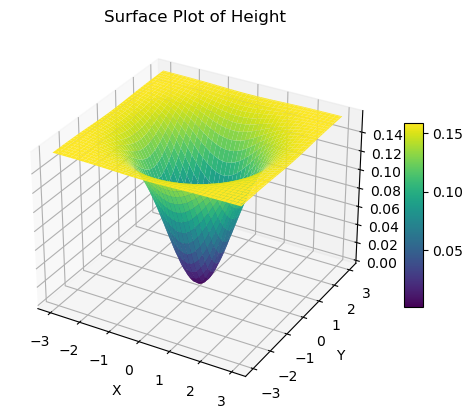

In [27]:
# Create the grid coordinates
# x, y = np.meshgrid(np.arange(size), np.arange(size))

# Create the figure and axis objects for the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create the surface plot
surf = ax.plot_surface(X, Y, psi_0, cmap='viridis')

# Add a colorbar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

# Add labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Surface Plot of Height')

# Show the plot
plt.show()

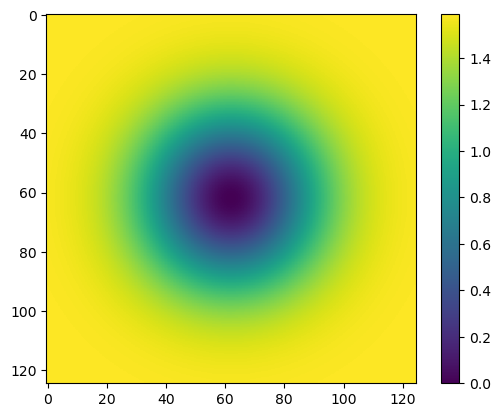

In [28]:
plt.imshow(H)
plt.colorbar()

-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888887e-05
-1.3760000012888

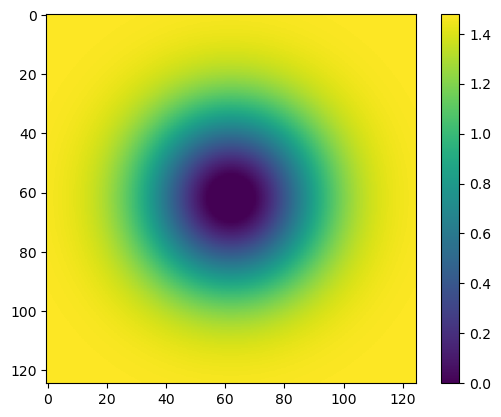

In [36]:
Hs = []
for _ in range(400):

    # dhdt = calc_dhdt(h, rho_water,rho_ice,s,pi_h, psi, m, delta_x)
    # cur_h = next_h(dhdt,delta_t,h)
    Ht = next_Ht(calc_dHtdt(H,m),delta_t,Ht)
    # h = cur_h
    H = H + calc_dHtdt(H,m)*delta_t
    # psi = calc_psi(Ht, h, H_ref) # psi for the next step
    print(np.mean(calc_dHtdt(H,m)))
    Hs.append(np.mean(H))


plt.imshow(H)
plt.colorbar()

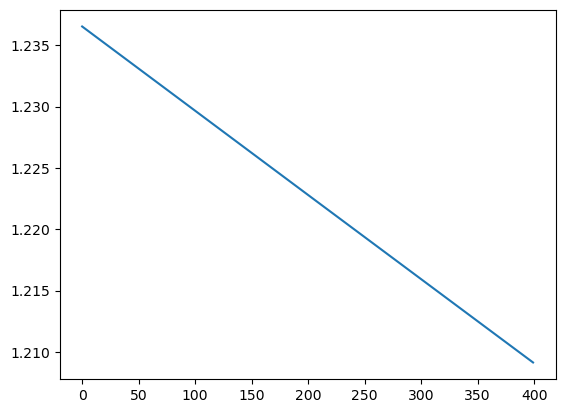

In [37]:
# checking that if we only melt and ignore water that we then get a steady decrease
plt.plot(Hs)

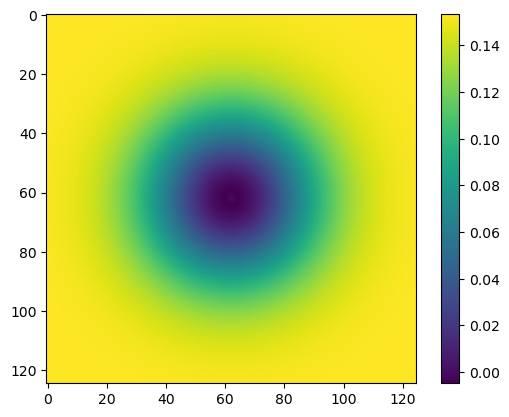

In [21]:
plt.imshow(Ht)
plt.colorbar()

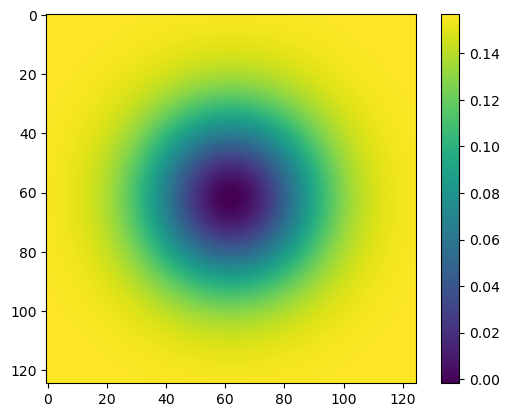

In [14]:
plt.imshow(psi)
plt.colorbar()

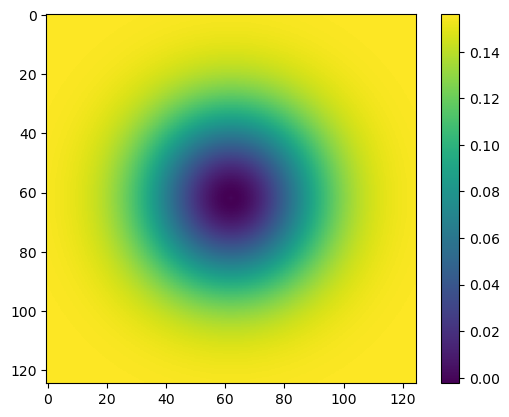

In [15]:
plt.imshow(Ht)
plt.colorbar()

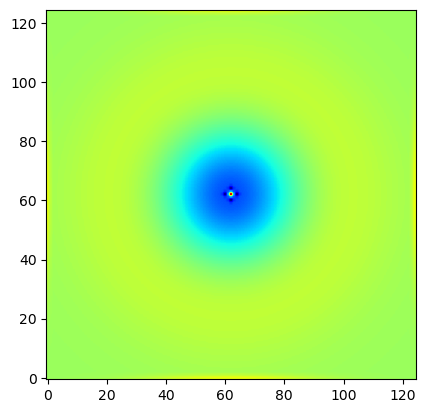

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Define the animation update function
def update(frame):
    global h
    psi = calc_psi(np.ones(h.shape), h, np.zeros(h.shape))
    dhdt = calc_dhdt(rho_water, rho_ice, s, pi_h, psi, m, delta_x)
    h = next_h(dhdt, delta_t, h)
    im.set_array(h)
    return im,

# Initialize the figure
fig, ax = plt.subplots()
im = ax.imshow(h, cmap='jet', origin='lower')

# Set the animation interval and create the animation
animation = FuncAnimation(fig, update, frames=range(100), interval=200)

# Display the animation
plt.show()

In [17]:
h

array([[0.00064815, 0.00064815, 0.00064815, ..., 0.00064815, 0.00064815,
        0.00064815],
       [0.00064815, 0.00064815, 0.00064815, ..., 0.00064815, 0.00064815,
        0.00064815],
       [0.00064815, 0.00064815, 0.00064815, ..., 0.00064815, 0.00064815,
        0.00064815],
       ...,
       [0.00064815, 0.00064815, 0.00064815, ..., 0.00064815, 0.00064815,
        0.00064815],
       [0.00064815, 0.00064815, 0.00064815, ..., 0.00064815, 0.00064815,
        0.00064815],
       [0.00064815, 0.00064815, 0.00064815, ..., 0.00064815, 0.00064815,
        0.00064815]])

In [18]:
#H_t = 0 # upper surface of the ice block
#H_b = -7 # lower surface of the ice block
#H = H_t - H_b # depth of the ice block

#h = 7 # height of the water layer
#H_ref = -3 # Reference point: distance between top layer and average ice height
#x,y = 0,0 # later lattice; coordinates

In [19]:
equation_3_delta_h = lambda input: 0.2
equation_4_m = lambda input: 7
equation_6_delta_H = lambda input: 0.2